In [27]:
import os
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from datetime import datetime
import kagglehub
import time
import gc
import torch.optim as optim
from torchvision import models
import glob
import pandas as pd

In [29]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Download latest version
data_dir = kagglehub.dataset_download("alessiocorrado99/animals10")
data_dir = os.path.join(data_dir, 'raw-img')
print("Path to dataset files:", data_dir)

classes = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "scoiattolo": "squirrel",
    "ragno": "spider"
}

data = {
    "path": [],
    "label": []
}

# Collect data paths and labels
for label_it, label_en in classes.items():
    paths = glob.glob(f'{data_dir}/{label_it}/*.jpeg')
    data["path"].extend(paths)
    data["label"].extend([label_en] * len(paths))

df_data = pd.DataFrame(data)
df_data.head()

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),  # Lightweight augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Dataset = datasets.ImageFolder(root=data_dir, transform=transform)

num_epochs = 10
batch_size = 32
learning_rate = 0.001


# Print number of classes and samples
num_classes = len(Dataset.classes)
print(f"Number of classes: {num_classes}")
num_samples = len(Dataset)
print(f"Number of samples: {num_samples}")

train_size = int(0.8 * len(Dataset))  # 80% for training
test_size = len(Dataset) - train_size  # 20% for testing

# Split dataset
train_dataset, test_dataset = random_split(Dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


Path to dataset files: C:\Users\hp\.cache\kagglehub\datasets\alessiocorrado99\animals10\versions\2\raw-img
Number of classes: 10
Number of samples: 26179


In [31]:
import torch
import torch.nn as nn
from torchvision import models

# Function to initialize and modify the ResNet18 model
def initialize_resnet18(num_classes, device):
    """
    Initialize and modify the ResNet18 model for a specific number of classes.
    
    Args:
        num_classes (int): Number of output classes.
        device (torch.device): The device to load the model onto (CPU/GPU).
    
    Returns:
        model (torch.nn.Module): Modified ResNet18 model.
    """
    # Load the pre-trained ResNet18 model
    model = models.resnet18(weights='ResNet18_Weights.DEFAULT')

    # Modify the fully connected layer to match the number of classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    # Move the model to the specified device
    model = model.to(device)

    return model

# Define the number of classes (adjust based on your dataset)
NUM_CLASSES = 10  # Update based on your dataset

# Select the device (GPU if available, else CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Initialize the ResNet18 model
model = initialize_resnet18(NUM_CLASSES, DEVICE)

# Print model summary
print("Modified ResNet18 Model:")
print(model)



Using device: cuda
Modified ResNet18 Model:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [33]:
import os
import time
import torch
import gc
from torch import nn, optim
from torchvision import models

# Create a directory to save logs if it doesn't exist
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)
log_file_path = os.path.join(log_dir, "resnet18_training_logs.txt")

# Arrays to store batch times for training and validation
train_batch_times = []
validation_batch_times = []

# Arrays to store training and validation metrics
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Open log file for writing
with open(log_file_path, "w") as log_file:
    def log_and_print(message):
        log_file.write(message + "\n")
        print(message)

    log_and_print("Training and Validation Logs for ResNet18")
    log_and_print("=" * 50)

    for epoch in range(num_epochs):
        epoch_loss = 0  # Accumulate loss for the epoch
        epoch_start_time = time.time()  # Start epoch timer
        correct_train = 0
        total_train = 0

        log_and_print(f"\nEpoch [{epoch + 1}/{num_epochs}]")

        for i, (images, labels) in enumerate(train_loader):
            batch_start_time = time.time()  # Start batch timer

            # Move tensors to the configured device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Clean up
            del images, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()

            # Update epoch loss
            epoch_loss += loss.item()

            # Record batch time
            batch_end_time = time.time()
            batch_time = batch_end_time - batch_start_time
            train_batch_times.append(batch_time)

            # Log and print progress every 10 batches
            if (i + 1) % 10 == 0:
                log_and_print(f"Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}, Batch Time: {batch_time:.2f} seconds")

        epoch_end_time = time.time()  # End epoch timer
        avg_epoch_loss = epoch_loss / len(train_loader)
        training_losses.append(avg_epoch_loss)
        training_accuracy = 100 * correct_train / total_train
        training_accuracies.append(training_accuracy)

        log_and_print(f"Epoch [{epoch + 1}/{num_epochs}] completed. Average Loss: {avg_epoch_loss:.4f}")
        log_and_print(f"Training Accuracy: {training_accuracy:.2f} %")
        log_and_print(f"Total Time for Epoch {epoch + 1}: {epoch_end_time - epoch_start_time:.2f} seconds")

        # Validation
        with torch.no_grad():
            correct = 0
            total = 0
            validation_loss = 0
            validation_start_time = time.time()  # Start validation timer

            log_and_print("Starting Validation...")

            for i, (images, labels) in enumerate(test_loader):
                batch_start_time = time.time()  # Start batch timer

                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                # Compute predictions
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Compute validation loss
                loss = criterion(outputs, labels)
                validation_loss += loss.item()

                # Record validation batch time
                batch_end_time = time.time()
                batch_time = batch_end_time - batch_start_time
                validation_batch_times.append(batch_time)

                # Log progress every 10 validation batches
                if (i + 1) % 10 == 0:
                    log_and_print(f"Validation Step [{i + 1}/{len(test_loader)}], Batch Time: {batch_time:.2f} seconds")

                # Clean up
                del images, labels, outputs
                torch.cuda.empty_cache()
                gc.collect()

            validation_end_time = time.time()  # End validation timer
            avg_validation_loss = validation_loss / len(test_loader)
            validation_losses.append(avg_validation_loss)
            accuracy = 100 * correct / total
            validation_accuracies.append(accuracy)

            log_and_print(f"Accuracy of the network on the validation set: {accuracy:.2f} %")
            log_and_print(f"Validation Loss: {avg_validation_loss:.4f}")
            log_and_print(f"Total Validation Time: {validation_end_time - validation_start_time:.2f} seconds")

# Save batch times for training and validation to separate files
train_times_path = os.path.join(log_dir, "train_batch_times.txt")
validation_times_path = os.path.join(log_dir, "validation_batch_times.txt")

with open(train_times_path, "w") as train_file:
    train_file.write("\n".join([f"{time:.4f}" for time in train_batch_times]))

with open(validation_times_path, "w") as val_file:
    val_file.write("\n".join([f"{time:.4f}" for time in validation_batch_times]))

# Save metrics to separate files
training_losses_path = os.path.join(log_dir, "training_losses.txt")
validation_losses_path = os.path.join(log_dir, "validation_losses.txt")
training_accuracies_path = os.path.join(log_dir, "training_accuracies.txt")
validation_accuracies_path = os.path.join(log_dir, "validation_accuracies.txt")

with open(training_losses_path, "w") as train_loss_file:
    train_loss_file.write("\n".join([f"{loss:.4f}" for loss in training_losses]))

with open(validation_losses_path, "w") as val_loss_file:
    val_loss_file.write("\n".join([f"{loss:.4f}" for loss in validation_losses]))

with open(training_accuracies_path, "w") as train_acc_file:
    train_acc_file.write("\n".join([f"{acc:.2f}" for acc in training_accuracies]))

with open(validation_accuracies_path, "w") as val_acc_file:
    val_acc_file.write("\n".join([f"{acc:.2f}" for acc in validation_accuracies]))


log_and_print(f"Logs, metrics, and batch times saved in '{log_dir}' directory.")


Training and Validation Logs for ResNet18

Epoch [1/10]
Step [10/655], Loss: 2.0020, Batch Time: 1.40 seconds
Step [20/655], Loss: 1.7260, Batch Time: 0.95 seconds
Step [30/655], Loss: 0.9690, Batch Time: 1.06 seconds
Step [40/655], Loss: 0.7250, Batch Time: 0.97 seconds
Step [50/655], Loss: 0.7091, Batch Time: 2.55 seconds
Step [60/655], Loss: 0.3488, Batch Time: 1.02 seconds
Step [70/655], Loss: 0.5852, Batch Time: 0.87 seconds
Step [80/655], Loss: 0.3863, Batch Time: 0.96 seconds
Step [90/655], Loss: 0.5708, Batch Time: 0.93 seconds
Step [100/655], Loss: 0.6157, Batch Time: 1.03 seconds
Step [110/655], Loss: 0.3215, Batch Time: 0.97 seconds
Step [120/655], Loss: 0.4136, Batch Time: 0.98 seconds
Step [130/655], Loss: 0.5018, Batch Time: 0.97 seconds
Step [140/655], Loss: 0.3662, Batch Time: 1.46 seconds
Step [150/655], Loss: 0.2939, Batch Time: 1.00 seconds
Step [160/655], Loss: 0.6168, Batch Time: 0.95 seconds
Step [170/655], Loss: 0.2590, Batch Time: 0.99 seconds
Step [180/655], Lo

ValueError: I/O operation on closed file.

In [39]:
log_and_print(f"Logs, metrics, and batch times saved in '{log_dir}' directory.")

ValueError: I/O operation on closed file.

In [37]:
# Get the current date and time
current_timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Get the current working directory
log_dir = os.getcwd()

# Save the ResNet18 model with a timestamp in the filename
model_save_path = os.path.join(log_dir, f"resnet18_trained_model_{current_timestamp}-before-results-measuring.pth")
torch.save(model.state_dict(), model_save_path)

print(f"Model saved at '{model_save_path}' for later usage.")

Model saved at 'C:\Users\hp\cnn_training_testing\resnet18_trained_model_2025-01-17_11-44-52-before-results-measuring.pth' for later usage.


In [41]:
import os
from datetime import datetime
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Create a results directory with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = f"resnet18_results_{timestamp}"
os.makedirs(results_dir, exist_ok=True)

# Function to save a plot with 'resnet18' in the file name
def save_plot(data, xlabel, ylabel, title, filename, is_line_plot=True):
    plt.figure()
    if is_line_plot:
        plt.plot(data)
    else:
        sns.barplot(x=list(range(len(data))), y=data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    # Save with 'resnet18' in the filename
    plt.savefig(os.path.join(results_dir, f"resnet18_{filename}"))
    plt.close()

# Save training and validation batch times
save_plot(train_batch_times, "Batch Number", "Time (seconds)", "Training Batch Times", "resnet18_train_batch_times.png")
save_plot(validation_batch_times, "Batch Number", "Time (seconds)", "Validation Batch Times", "resnet18_validation_batch_times.png")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# In the evaluation function
def evaluate_model_on_test():
    y_true, y_pred = [], []
    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():
        for images, labels in test_loader:
            # Move both images and labels to the same device as the model
            images = images.to(device)
            labels = labels.to(device)

            # Perform forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Move tensors back to CPU and convert to numpy
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())


    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    # Save with 'resnet18' in the filename
    plt.savefig(os.path.join(results_dir, "resnet18_confusion_matrix.png"))
    plt.close()

    # Classification Report
    report = classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(num_classes)], output_dict=True)
    report_str = classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(num_classes)])
    print(report_str)  # Print to console
    # Save the classification report with 'resnet18' in the filename
    with open(os.path.join(results_dir, "resnet18_classification_report.txt"), "w") as f:
        f.write(report_str)

    return cm, report

confusion_matrix_data, classification_report_data = evaluate_model_on_test()

# Save training and validation loss and accuracy curves
# Assuming `training_losses`, `validation_losses`, `training_accuracies`, `validation_accuracies` lists are collected during training
save_plot(training_losses, "Epoch", "Loss", "Training Loss Curve", "resnet18_training_loss_curve.png")
save_plot(validation_losses, "Epoch", "Loss", "Validation Loss Curve", "resnet18_validation_loss_curve.png")
save_plot(training_accuracies, "Epoch", "Accuracy (%)", "Training Accuracy Curve", "resnet18_training_accuracy_curve.png")
save_plot(validation_accuracies, "Epoch", "Accuracy (%)", "Validation Accuracy Curve", "resnet18_validation_accuracy_curve.png")

# Save the model architecture and training configuration
with open(os.path.join(results_dir, "resnet18_model_summary.txt"), "w") as f:
    f.write(str(model))
    f.write("\n\nTraining Configuration:\n")
    f.write(f"Number of Epochs: {num_epochs}\n")
    f.write(f"Learning Rate: {learning_rate}\n")
    f.write(f"Optimizer: SGD (momentum=0.9, weight_decay=0.001)\n")
    f.write(f"Loss Function: CrossEntropyLoss\n")

overall_results = {
    "Average Training Batch Time": np.mean(train_batch_times),
    "Average Validation Batch Time": np.mean(validation_batch_times),
    "Final Validation Accuracy": classification_report_data["accuracy"] * 100,
}

# Write results to a file
with open(os.path.join(results_dir, "resnet18_overall_results.txt"), "w") as f:
    for key, value in overall_results.items():
        f.write(f"{key}: {value:.2f}\n")

print(f"Reports and visualizations saved in '{results_dir}' directory.")


# Get the current date and time for model save
current_timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Save the model with a timestamp in the filename
model_save_path = os.path.join(results_dir, f"resnet18_trained_model_{current_timestamp}.pth")
torch.save(model.state_dict(), model_save_path)

print(f"Model saved at '{model_save_path}' for later usage.")


              precision    recall  f1-score   support

     Class 0       0.92      0.94      0.93       986
     Class 1       0.92      0.92      0.92       530
     Class 2       0.95      0.96      0.95       270
     Class 3       0.95      0.97      0.96       433
     Class 4       0.98      0.97      0.97       638
     Class 5       0.93      0.89      0.91       341
     Class 6       0.87      0.91      0.89       357
     Class 7       0.93      0.89      0.91       340
     Class 8       0.98      0.99      0.99       974
     Class 9       0.96      0.93      0.95       367

    accuracy                           0.94      5236
   macro avg       0.94      0.94      0.94      5236
weighted avg       0.94      0.94      0.94      5236

Reports and visualizations saved in 'resnet18_results_20250117_114628' directory.
Model saved at 'resnet18_results_20250117_114628\resnet18_trained_model_2025-01-17_11-47-34.pth' for later usage.


In [22]:
# print(classification_report_data)

C:\Users\hp\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\hp\AppData\Local\Temp\ipykernel_10140\3617380357.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `Tr

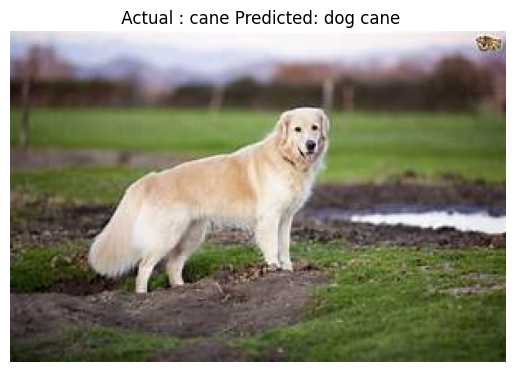

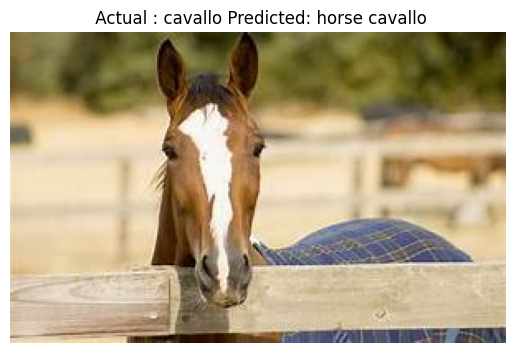

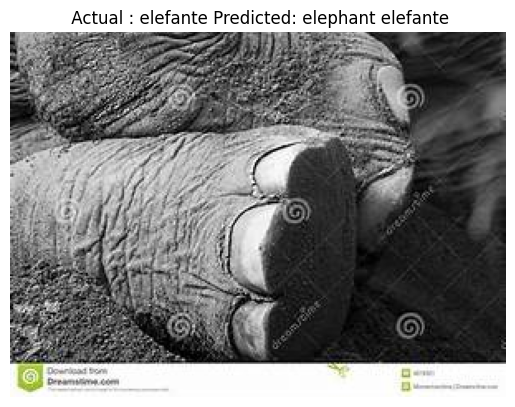

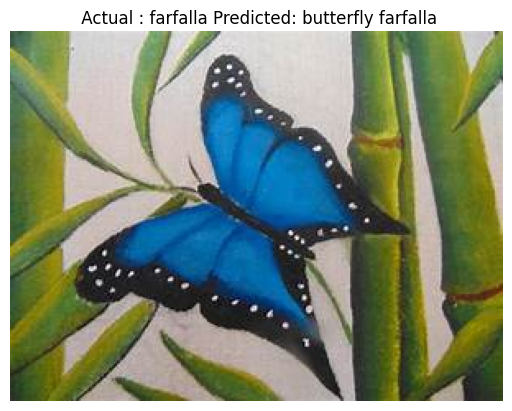

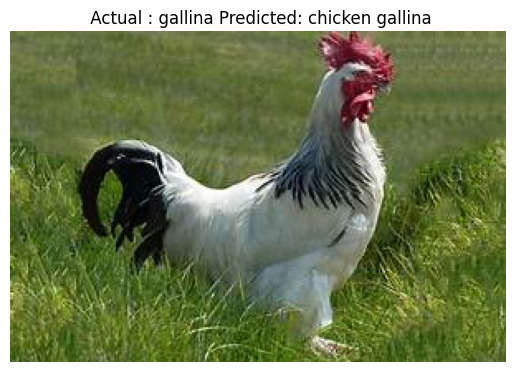

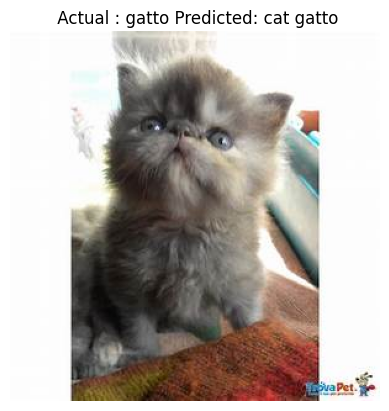

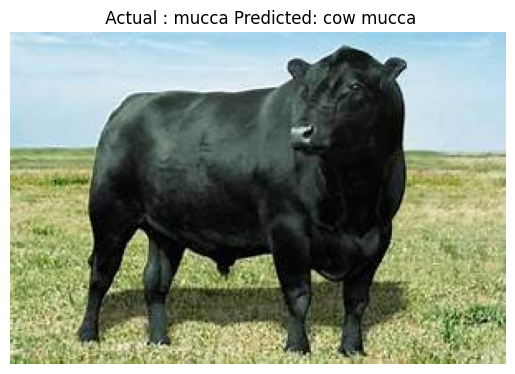

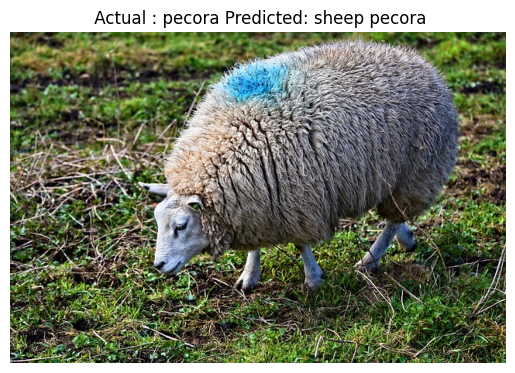

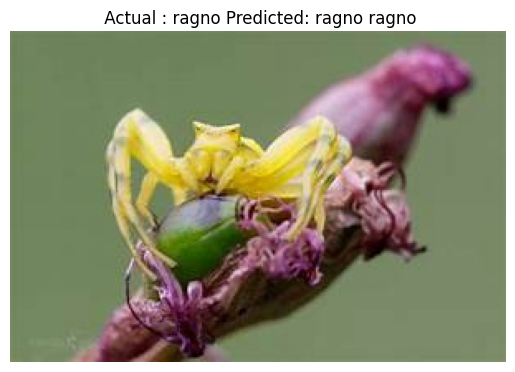

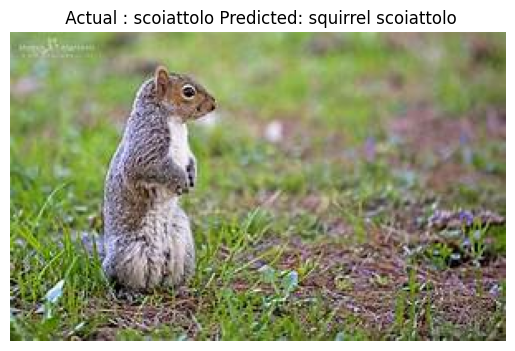

In [45]:
import os
import random
from PIL import Image
import torch
from torchvision import models, transforms
import torch.nn as nn
import matplotlib.pyplot as plt

# Define batch size and image dimensions
BATCH_SIZE = 32
IMG_HEIGHT = 128  # Adjust according to your dataset
IMG_WIDTH = 128   # Adjust according to your dataset

# Define the translation dictionary
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", 
    "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", 
    "scoiattolo": "squirrel", "dog": "cane", "horse": "cavallo", "elephant": "elefante", 
    "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", 
    "spider": "ragno", "squirrel": "scoiattolo"
}

# Define the categories (class names your model predicts)
categories = ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']

# Define the dataset directory path (replace with your actual path)
dataset_dir = r'C:\Users\hp\.cache\kagglehub\datasets\alessiocorrado99\animals10\versions\2\raw-img'

# Define the transformations to match what was done during training
transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),  # Resize to match model input size
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
])

# Load the pre-trained ResNet18 model and modify the final layer
model = models.resnet18(pretrained=False)  # Load ResNet18 without the weights
model.fc = nn.Linear(model.fc.in_features, len(categories))  # Modify the final layer to match the number of classes

# Load the saved model weights (ensure this path is correct relative to your script)
model_path = './resnet18_results_20250117_114628/resnet18_trained_model_2025-01-17_11-47-34.pth'  # Using relative path if the model is in the same directory
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

# Function to test a random image from each class
def test_random_images(model, categories, dataset_dir, transform):
    model.eval()  # Set the model to evaluation mode
    for category in categories:
        # Get all image files in the current category directory
        class_dir = os.path.join(dataset_dir, category)
        image_files = os.listdir(class_dir)
        
        # Select a random image
        random_image = random.choice(image_files)
        image_path = os.path.join(class_dir, random_image)
        
        # Open and preprocess the image
        img = Image.open(image_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
        
        # Make prediction
        with torch.no_grad():
            outputs = model(img_tensor)  # Get model output
            _, predicted_class_idx = torch.max(outputs, 1)  # Get index of the max value in the output
        
        # Get the predicted class label
        predicted_class_label = categories[predicted_class_idx.item()]  # Convert the index to class label
        
        # Translate the predicted class label
        translated_label = translate.get(predicted_class_label, predicted_class_label)  # Get the translated label or keep the original if not found
        
        # Display the image and the translated prediction
        plt.imshow(img)
        plt.title(f" Actual : {category} Predicted: {translated_label} {predicted_class_label}")
        plt.axis('off')  # Hide the axes for a cleaner view
        plt.show()

# Test random images from each class
test_random_images(model, categories, dataset_dir, transform)
